## CHANGES

- validation set is continguous with training set (vs random sample)
- added other image transforms using gramian angular field
- even bigger custom head

## SETUP

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [171]:
import fastai
from fastai.vision import *
from fastai.callbacks import *

In [3]:
# show versions
print('fastai:', fastai.__version__)
print('pytorch:', torch.__version__)
print('python:', sys.version.split(' ')[0])

fastai: 1.0.48
pytorch: 1.0.1.post2
python: 3.6.7


In [129]:
version = 'v6'       # this should match the notebook filename

seed = 42
arch = models.resnet50
size = 224  # (y, x)
bs = 32
num_workers = 6     # set to available cores

transform = 'spectogram'  # which time series to visual transformation to use

In [130]:
# set seed
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

## DATA

Assumes the following has been generated using `gen_spectogram`:
- `X_train.csv`
- `y_train.csv`
- `train_images`
- `test_images`

In [131]:
path = pathlib.Path.home()/'.fastai/data/kaggle_earthquake'
path.ls()

[PosixPath('/root/.fastai/data/kaggle_earthquake/sample_submission.csv'),
 PosixPath('/root/.fastai/data/kaggle_earthquake/test.zip'),
 PosixPath('/root/.fastai/data/kaggle_earthquake/train.csv.zip'),
 PosixPath('/root/.fastai/data/kaggle_earthquake/train.csv'),
 PosixPath('/root/.fastai/data/kaggle_earthquake/X_train.csv'),
 PosixPath('/root/.fastai/data/kaggle_earthquake/y_train.csv'),
 PosixPath('/root/.fastai/data/kaggle_earthquake/saved_models'),
 PosixPath('/root/.fastai/data/kaggle_earthquake/train'),
 PosixPath('/root/.fastai/data/kaggle_earthquake/submission.csv'),
 PosixPath('/root/.fastai/data/kaggle_earthquake/submission_v6.csv'),
 PosixPath('/root/.fastai/data/kaggle_earthquake/train_images'),
 PosixPath('/root/.fastai/data/kaggle_earthquake/test_images'),
 PosixPath('/root/.fastai/data/kaggle_earthquake/test')]

In [132]:
# look at images dir
img_path = path/f'train_images/{transform}'
img_path.ls()[:5]

[PosixPath('/root/.fastai/data/kaggle_earthquake/train_images/spectogram/seg_0.png'),
 PosixPath('/root/.fastai/data/kaggle_earthquake/train_images/spectogram/seg_1.png'),
 PosixPath('/root/.fastai/data/kaggle_earthquake/train_images/spectogram/seg_2.png'),
 PosixPath('/root/.fastai/data/kaggle_earthquake/train_images/spectogram/seg_3.png'),
 PosixPath('/root/.fastai/data/kaggle_earthquake/train_images/spectogram/seg_4.png')]

In [133]:
# look at saved models dir
save_path = path/'saved_models'
if not os.path.isdir(save_path):
    os.mkdir(save_path)
save_path.ls()[:5]

[PosixPath('/root/.fastai/data/kaggle_earthquake/saved_models/v5-stage-1-1.pth'),
 PosixPath('/root/.fastai/data/kaggle_earthquake/saved_models/v5-stage-1-2.pth'),
 PosixPath('/root/.fastai/data/kaggle_earthquake/saved_models/v6-stage-1-1.pth'),
 PosixPath('/root/.fastai/data/kaggle_earthquake/saved_models/v6-stage-1-2.pth'),
 PosixPath('/root/.fastai/data/kaggle_earthquake/saved_models/v6-stage-2-1.pth')]

In [134]:
# load segment CSVs
pd.options.display.precision = 15
X_train = pd.read_csv(path/'X_train.csv', index_col=0)
y_train = pd.read_csv(path/'y_train.csv', index_col=0)

In [135]:
X_train.head()

,ave,std,max,min
0,4.884113333333334,5.101089126891323,104.0,-98.0
1,4.725766666666667,6.588801819164258,181.0,-154.0
2,4.906393333333333,6.967373808828945,140.0,-106.0
3,4.902240000000000,6.922282112791033,197.0,-199.0
4,4.908720000000000,7.301085852684289,145.0,-126.0


In [136]:
y_train.head()

,time_to_failure
0,1.4307971859
1,1.3914988931
2,1.3531960947
3,1.3137978019
4,1.2743995091


## MODEL

In [137]:
def gen_label(path):
    id = int(path.name.split('_')[1].split('.')[0])
    ttf = y_train.iloc[id]['time_to_failure']
    return ttf

In [138]:
gen_label(img_path/'seg_0.png')

1.4307971859

In [139]:
# no data augmentation
tfms = get_transforms(do_flip=False, p_affine=0., p_lighting=0.)

In [140]:
fake_label = 0.
valid_idx = range(3000, len(y_train))

src = (ImageList.from_folder(img_path)
        .split_by_idx(valid_idx=valid_idx)
        .label_from_func(gen_label, label_cls=FloatList)
        .add_test_folder(f'../../test_images/{transform}', label=fake_label))

In [141]:
data = (src.transform(tfms, resize_method=ResizeMethod.SQUISH, size=size)
        .databunch(bs=bs, num_workers=num_workers)
        .normalize(imagenet_stats))

In [142]:
# verify datasets loaded properly
n_train_items = len(data.train_ds)
n_valid_items = len(data.valid_ds)
n_test_items = len(data.test_ds)

print('train: ', n_train_items)
print('valid: ', n_valid_items)
print('test:  ', n_test_items)
print('')
print('TOTAL: ', n_train_items + n_valid_items + n_test_items)

train:  3000
valid:  1194
test:   2624

TOTAL:  6818


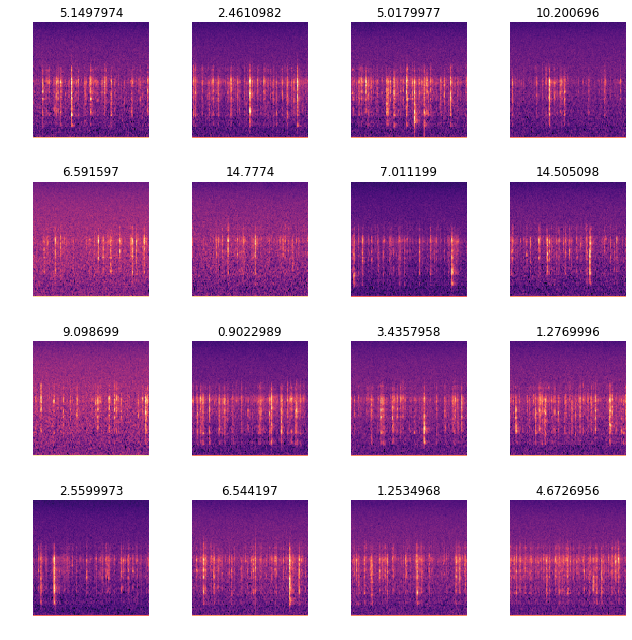

In [143]:
# verify images and labels match up
data.show_batch(4, figsize=(9, 9))

In [144]:
# define metrics
def mse(preds, targs):
    return mean_squared_error(preds.view(-1), targs.view(-1))

def mae(preds, targs):
    return mean_absolute_error(preds.view(-1), targs.view(-1))

In [145]:
# L1 loss is sum of the all the absolute differences
# more robust to outliers
l1loss = nn.L1Loss()
def l1_loss(preds, targs):
    return l1loss(preds.view(-1), targs.view(-1))

# L2 loss is sum of the all the squared differences
# less robust to outliers
l2loss = nn.MSELoss()
def l2_loss(preds, targs):
    return l2loss(preds.view(-1), targs.view(-1))

In [146]:
# return correct size of fully connected layer based on pre-trained model
def final_conv_layer_size(arch):
    if arch == models.resnet18 and size == (217, 223): return 512*14*21
    elif arch == models.resnet34 and size == (217, 223): return 512*7*7  
    elif arch == models.resnet50 and size == (217, 223): return 2048*7*7
    elif arch == models.resnet50 and size == 224: return 2048*7*7

In [192]:
# define custom heads
small_head_reg1 = nn.Sequential(Flatten(), nn.Linear(final_conv_layer_size(arch), 1))

medium_head_reg1 = nn.Sequential(
  nn.AvgPool2d(7, 7),
  Flatten(), 
  nn.BatchNorm1d(2048),
  nn.Dropout(0.5),
  nn.Linear(2048, 256),
  nn.ReLU(),
  nn.BatchNorm1d(256),
  nn.Dropout(0.5),
  nn.Linear(256, 1))

big_head_reg1 = nn.Sequential(
  nn.AvgPool2d(7, 7),
  Flatten(), 
  nn.BatchNorm1d(2048),
  nn.Dropout(0.5),
  nn.Linear(2048, 512),
  nn.ReLU(),
  nn.BatchNorm1d(512),
  nn.Dropout(0.5),
  nn.Linear(512, 128),
  nn.ReLU(),
  nn.BatchNorm1d(128),
  nn.Dropout(0.5),
  nn.Linear(128, 1))

In [193]:
learn = cnn_learner(data, arch,
                    custom_head=big_head_reg1,
                    loss_func=l1_loss,
                    metrics=[mean_squared_error, mean_absolute_error])

In [194]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [1, 64, 112, 112]    9,408      False     
______________________________________________________________________
BatchNorm2d          [1, 64, 112, 112]    128        True      
______________________________________________________________________
ReLU                 [1, 64, 112, 112]    0          False     
______________________________________________________________________
MaxPool2d            [1, 64, 56, 56]      0          False     
______________________________________________________________________
Conv2d               [1, 64, 56, 56]      4,096      False     
______________________________________________________________________
BatchNorm2d          [1, 64, 56, 56]      128        True      
______________________________________________________________________
Conv2d               [1, 64, 56, 56]      36,864     False     
______________________________________________________________

## TRAIN

#### Stage 1-1

In [195]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


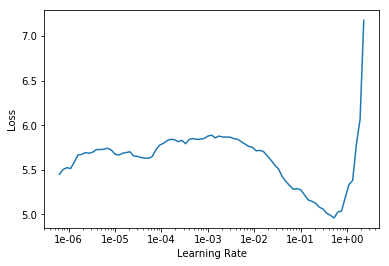

In [196]:
learn.lr_find()
learn.recorder.plot()

In [197]:
learn.fit_one_cycle(4, max_lr=slice(2e-2), callbacks=[
    SaveModelCallback(learn, monitor='mean_absolute_error', mode='min', every='improvement', name='best')])

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,3.322114,2.403454,10.353732,2.403454,00:14
1,2.496976,2.137375,8.719720,2.137375,00:14
2,2.206987,2.201019,8.472980,2.201018,00:14
3,1.979003,2.251152,8.303507,2.251152,00:14


Better model found at epoch 0 with mean_absolute_error value: 2.403454303741455.
Better model found at epoch 1 with mean_absolute_error value: 2.1373753547668457.


In [198]:
learn.save(save_path/f'{version}-stage-1-1')

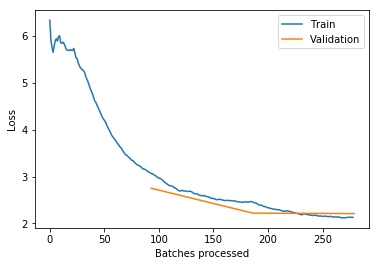

In [38]:
learn.recorder.plot_losses()

#### Stage 1-2

In [39]:
#learn.load(save_path/f'{version}-stage-1-1');

In [40]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


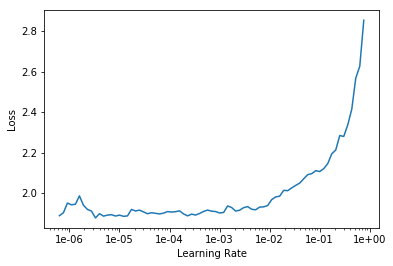

In [41]:
learn.lr_find()
learn.recorder.plot()

In [42]:
learn.fit_one_cycle(3, max_lr=slice(2e-4))

epoch,train_loss,valid_loss,mse,mae,time
0,1.936531,2.213233,8.278555,2.213233,00:14
1,1.911078,2.217913,8.282100,2.217913,00:14
2,1.945412,2.246893,8.277278,2.246893,00:14


In [43]:
learn.save(save_path/f'{version}-stage-1-2')

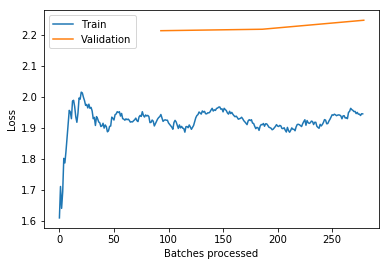

In [44]:
learn.recorder.plot_losses()

#### Stage 2-1

In [45]:
#learn.load(save_path/f'{version}-stage-1-2');

In [162]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


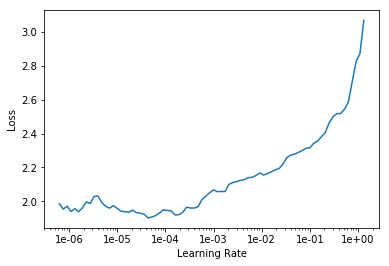

In [163]:
learn.lr_find()
learn.recorder.plot()

In [164]:
learn.fit_one_cycle(4, max_lr=slice(1e-6, 1e-5))

epoch,train_loss,valid_loss,mse,mae,time
0,1.875854,2.184428,8.091327,2.184428,00:19
1,1.843079,2.170894,8.087762,2.170894,00:19
2,1.723533,2.211883,8.323673,2.211883,00:19
3,1.670783,2.250584,8.343580,2.250584,00:19


In [49]:
learn.save(save_path/f'{version}-stage-2-1')

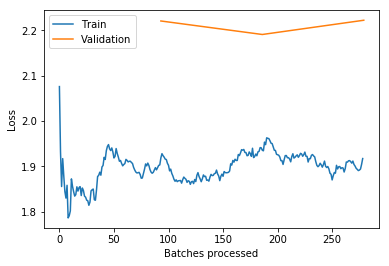

In [50]:
learn.recorder.plot_losses()

## RESULTS

In [51]:
# plot histograms of results
def plot_histograms(preds, targs):
    fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 8))
    fig.suptitle("Histograms of segment's time to failure")

    ax1.hist(preds.squeeze(), bins=50); ax1.set_xlabel('preds TTF'); ax1.set_ylabel('No. of segments')
    ax2.hist(targs, bins=50); ax2.set_xlabel('targs TTF'); ax2.set_ylabel('No. of segments')

#### Training Set

In [123]:
train_preds, train_targs = learn.get_preds(ds_type=DatasetType.Fix)

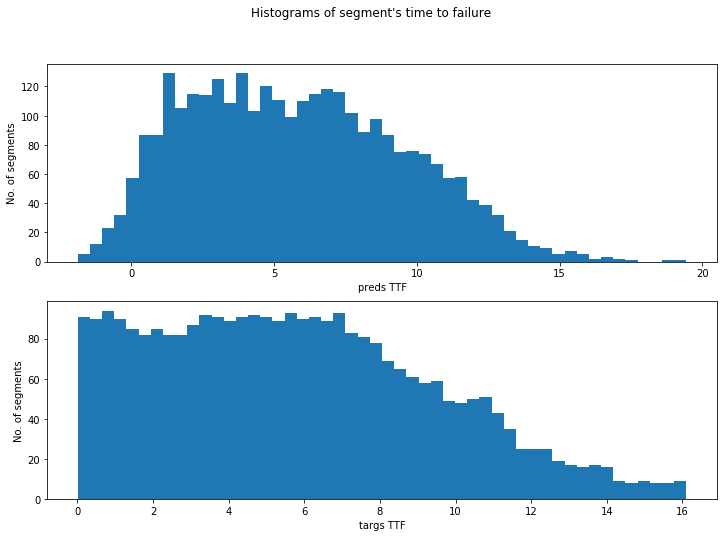

In [124]:
plot_histograms(train_preds, train_targs)

#### Validation Set

In [120]:
valid_preds, valid_targs = learn.get_preds(ds_type=DatasetType.Valid)

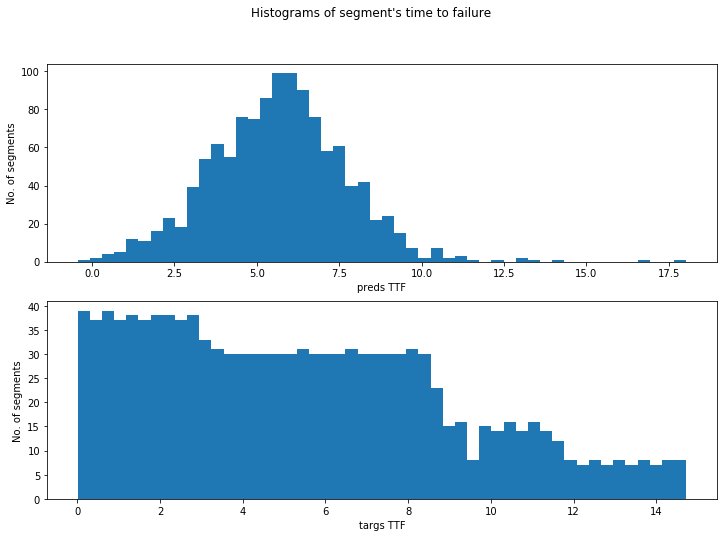

In [121]:
plot_histograms(valid_preds, valid_targs)

#### Test Set

In [56]:
test_preds, test_targs = learn.get_preds(ds_type=DatasetType.Test)

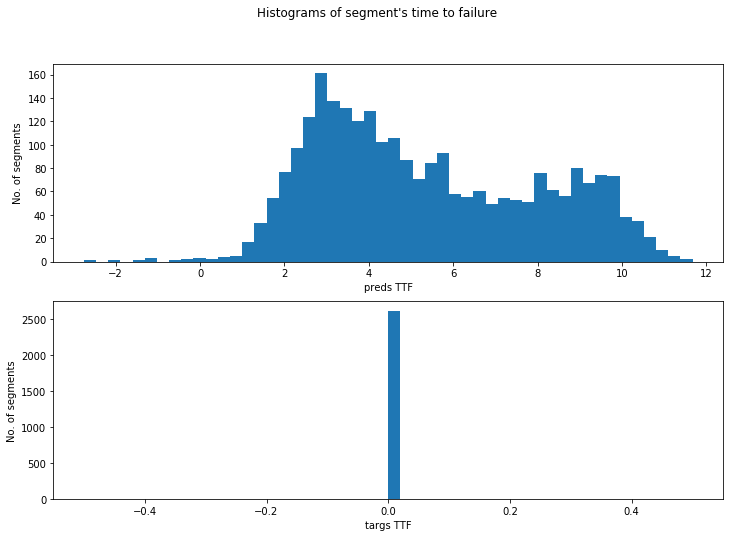

In [57]:
plot_histograms(test_preds, test_targs)

## SUBMISSION

In [ ]:
# load sample submission
submission = pd.read_csv(path/'sample_submission.csv', index_col='seg_id')

In [ ]:
# assume order of test set is unchanged
submission['time_to_failure'] = [test_preds[i].item() for i in range(len(test_preds))]

In [ ]:
submission.head()

In [ ]:
submission.to_csv(path/'submission.csv')

In [ ]:
# submit to leaderboard
! cd $path; kaggle competitions submit -c LANL-Earthquake-Prediction -f submission.csv -m "Message"

In [ ]:
# Public Score: 